# Analyzing and modeling datasets

## Importing and performing rudimentary analysis

In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd

In [2]:
the_rng = np.random.default_rng(seed=7)

## Basic modeling and inference of data

### Terminology

- **Feature:** column name, independent variable, some type of data that can be related to the output variable
- **Target:** the dependent variable or output of the model
- **Instance:** a "row" or observation of data that includes the independent variables and the dependent variable
- **Training data:** instances used for building the regression/classification model
- **Testing data:** instances used for testing the validity of the regression/classification model
- **Residual:** the difference between the estimated output values from the model and the true output values from the data
- **Inference:** Inferring the properties of an underlying distribution (making conclusions from data subject to random variation).
- **Parameter:** a summary statistic of the population we are interested in

### Distributions

This class will be all about distributions.  Why?

Because all physical data and models are about distributions.

In this module of EE 5020, we focus on **frequentist** (classical) statistics, where we assume the Gaussian and whether features can be parameterized as such.

You'll see Bayesian statistics in the next module, where data is treated as informing a probability estimate instead.

#### Distribution terminology
- **pdf:** probability density function, probability for each possible value of a **continuous** random variable
- **pmf:** probability mass function, probability for each possible value of a **discrete** random variable
- **cdf:** cumulative distribution function, cumulative probability for each value (and the ones before it)
- **samples:** just like with signals, samples (instant values) are drawn from a random variable (which conforms to some distribution)

#### Trying out distributions

Let's try to draw some samples and plot a few distributions using NumPy:

[10  6  7  9  6  8  9  2  0  3]


<AxesSubplot:ylabel='Count'>

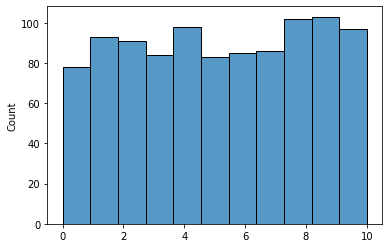

In [3]:
random_integer_sample = the_rng.integers(low=0, high=10, endpoint=True, size=1000)
print(random_integer_sample[0:10])
sns.histplot(data=random_integer_sample)

<AxesSubplot:ylabel='Count'>

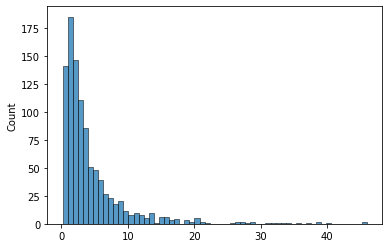

In [4]:
lognormal_sample = the_rng.lognormal(mean=1.0, sigma=1.0, size=1000)
sns.histplot(data=lognormal_sample)

Now let's try to draw some samples and plot a few distributions using SciPy:

<AxesSubplot:ylabel='Count'>

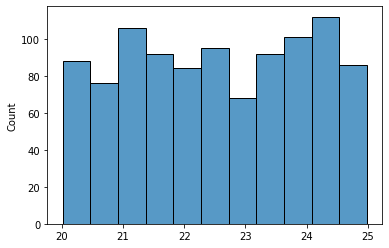

In [5]:
uniform_sample = sp.stats.uniform.rvs(loc=20., scale=5., size=1000, random_state=the_rng)
sns.histplot(data=uniform_sample)

<AxesSubplot:ylabel='Count'>

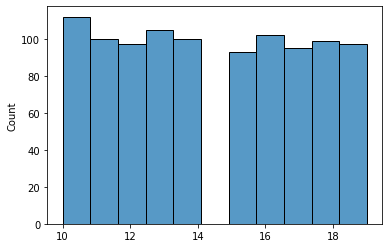

In [6]:
randint_sample = sp.stats.randint.rvs(low=10, high=20, size=1000, random_state=the_rng)
sns.histplot(data=randint_sample)

The special thing about SciPy distributions are that you can generate a "frozen" random variable, meaning that you can set the low, high, random state, etc. of a distribution, and just keep drawing from that same distribution.

To do this, rather than calling the `.rvs()` function of the distribution name, create the distribution as an object, then call `.rvs()` on your named distribution object instead, as I'll show.

Let's pretend that the optimal performance of an integrated circuit relative to its clock speed can be modeled as a Rayleigh distribution with a peak at 120 MHz and a scale of 20 MHz:

In [7]:
dist_ic_perf_clockspeed_peak = 120.
dist_ic_perf_clockspeed_spread = 20.

dist_ic_perf_clockspeed = sp.stats.rayleigh(loc=dist_ic_perf_clockspeed_peak - dist_ic_perf_clockspeed_spread,
                                            scale=dist_ic_perf_clockspeed_spread)

Text(0.5, 0, 'Clock speed (MHz)')

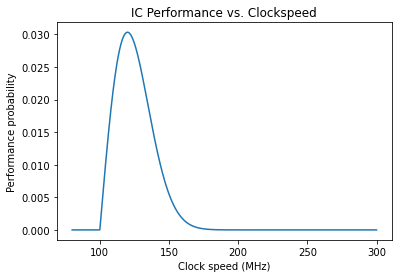

In [8]:
# examine the pdf directly rather than drawing samples:
dist_ic_perf_clockspeed_pdf_x = np.linspace(start=80., stop=300., num=1000)
dist_ic_perf_clockspeed_pdf_y = dist_ic_perf_clockspeed.pdf(dist_ic_perf_clockspeed_pdf_x)

dist_ic_perf_clockspeed_pdf_plot = sns.lineplot(
    x=dist_ic_perf_clockspeed_pdf_x, y=dist_ic_perf_clockspeed_pdf_y)

dist_ic_perf_clockspeed_pdf_plot.set_title("IC Performance vs. Clockspeed")
dist_ic_perf_clockspeed_pdf_plot.set_ylabel("Performance probability")
dist_ic_perf_clockspeed_pdf_plot.set_xlabel("Clock speed (MHz)")

The neatest thing is that you can attempt to fit data with a continuous distribution and examine the potential fits!

For more info, see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html#scipy.stats.rv_continuous.fit

We'll see if we can fit our perfectly uniform data (literally just repeated increments of numbers) to a uniform continuous distribution!

In [9]:
data_perfect = np.repeat(np.arange(0, 10.5, 0.1), 10)  # include the endpoint 10.4
print(data_perfect)

[ 0.   0.   0.  ... 10.4 10.4 10.4]


In [10]:
sp.stats.uniform.fit(data=data_perfect)  # returns parameters for the uniform distribution

(0.0, 10.4)

### Linear regression

Let's try using the `statsmodels` for linear regression!  There's a few different methods we'll go over, [see the statsmodels documentation on linear regression](https://www.statsmodels.org/stable/regression.html).

Why do we think about distributions when we are performing linear regression?  Because all of our analysis assumes the following:

![linear regression](./linear_regression.png)

Sometimes, a feature can be transformed using the `np.log10()` or `np.log()` function to attempt to normalize it.

#### Building models using toy data

Let's visualize this by making up some toy problems before we build models of real datasets.

We'll make a simple regression problem based on sampling from the equation `y = 2x + 5`.  We'll set up the vectors, then add some noise and attempt linear regression plots.

In [11]:
toy_sample_size = 21
toy_sample_bound_left = -10.0
toy_sample_bound_right = 10.0

toy_x = np.linspace(start=toy_sample_bound_left,
                    stop=toy_sample_bound_right,
                    num=toy_sample_size)

In [12]:
toy_y = 2. * toy_x + 5.
print(toy_y)

[-15. -13. -11.  -9.  -7.  -5.  -3.  -1.   1.   3.   5.   7.   9.  11.
  13.  15.  17.  19.  21.  23.  25.]


<AxesSubplot:>

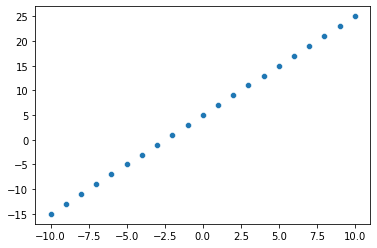

In [13]:
sns.scatterplot(x=toy_x, y=toy_y)

For info about OLS (ordinary least squares), see: https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html

Verify that we get the same model back when using `statsmodels` for regression using the "machine learning" API since we have no noise:

In [14]:
import statsmodels.regression.linear_model as slm
import statsmodels.api as sm

# add the intercept, which is just a vector of ones
toy_x_train = sm.add_constant(toy_x)

model_perfect = slm.OLS(endog=toy_y, exog=toy_x_train)
model_perfect_results = model_perfect.fit()
model_perfect_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.159e+33
Date:                Fri, 09 Sep 2022   Prob (F-statistic):          1.98e-303
Time:                        23:18:08   Log-Likelihood:                 686.31
No. Observations:                  21   AIC:                            -1369.
Df Residuals:                      19   BIC:                            -1367.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0000   3.56e-16   1.41e+16      0.000       5.000       5.000
x1             2.0000   5.87e-17    3.4e+16      0.000       2.000       2.000
==============================================================================
Omnibus:                        6.221   Durbin-Watson:                   0.062
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                5.502
Skew:                          -1.230   Prob(JB):                       0.0639
Kurtosis:                       2.512   Cond. No.                         6.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Note:** Another way of calling ordinary least squares in `statsmodels` is to use the "Formula API", which requires everything be in a `pandas` DataFrame, so we "swizzle" the `toy_x` and `toy_y` vectors into a DataFrame:

In [15]:
import statsmodels.formula.api as smf

df_toy = pd.DataFrame.from_dict({"x": toy_x, "y": toy_y})
f_model_perfect = smf.ols(formula='y ~ x + 1', data=df_toy)
f_model_perfect_results = f_model_perfect.fit()
f_model_perfect_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.159e+33
Date:                Fri, 09 Sep 2022   Prob (F-statistic):          1.98e-303
Time:                        23:18:08   Log-Likelihood:                 686.31
No. Observations:                  21   AIC:                            -1369.
Df Residuals:                      19   BIC:                            -1367.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.0000   3.56e-16   1.41e+16      0.000       5.000       5.000
x              2.0000   5.87e-17    3.4e+16      0.000       2.000       2.000
==============================================================================
Omnibus:                        6.221   Durbin-Watson:                   0.062
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                5.502
Skew:                          -1.230   Prob(JB):                       0.0639
Kurtosis:                       2.512   Cond. No.                         6.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

You'll notice that both methods of calling Ordinary Least Squares yield the same results, but the calls were different.  You can use either the machine learning API (where everything is in terms of an `X` feature matrix and `y` output vector) or the formula API (which is a bit more symbolic).

Now let's see how we noise affects our estimate:

<AxesSubplot:>

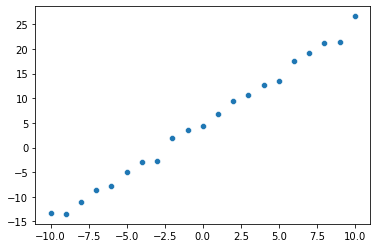

In [16]:
dist_noise = sp.stats.norm(loc=0., scale=1.0)

# reset the random number generator to a known state so our experiment is consistent
noise_samples = dist_noise.rvs(size=len(toy_x), random_state=7)

toy_noisy_y = toy_y + noise_samples

sns.scatterplot(x=toy_x, y=toy_noisy_y)

In [17]:
model_noisy = slm.OLS(endog=toy_noisy_y, exog=toy_x_train)
model_noisy_results = model_noisy.fit()
model_noisy_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3486.
Date:                Fri, 09 Sep 2022   Prob (F-statistic):           5.40e-23
Time:                        23:18:09   Log-Likelihood:                -27.346
No. Observations:                  21   AIC:                             58.69
Df Residuals:                      19   BIC:                             60.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9795      0.204     24.393      0.000       4.552       5.407
x1             1.9903      0.034     59.038      0.000       1.920       2.061
==============================================================================
Omnibus:                        0.071   Durbin-Watson:                   2.396
Prob(Omnibus):                  0.965   Jarque-Bera (JB):                0.059
Skew:                          -0.027   Prob(JB):                        0.971
Kurtosis:                       2.745   Cond. No.                         6.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
df_toy_noisy = pd.DataFrame.from_dict({"x": toy_x, "noisy_y": toy_noisy_y})
f_model_noisy = smf.ols(formula='noisy_y ~ x + 1', data=df_toy_noisy)
f_model_noisy_results = f_model_noisy.fit()
f_model_noisy_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                noisy_y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     3486.
Date:                Fri, 09 Sep 2022   Prob (F-statistic):           5.40e-23
Time:                        23:18:09   Log-Likelihood:                -27.346
No. Observations:                  21   AIC:                             58.69
Df Residuals:                      19   BIC:                             60.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9795      0.204     24.393      0.000       4.552       5.407
x              1.9903      0.034     59.038      0.000       1.920       2.061
==============================================================================
Omnibus:                        0.071   Durbin-Watson:                   2.396
Prob(Omnibus):                  0.965   Jarque-Bera (JB):                0.059
Skew:                          -0.027   Prob(JB):                        0.971
Kurtosis:                       2.745   Cond. No.                         6.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

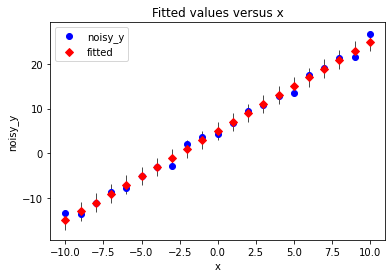

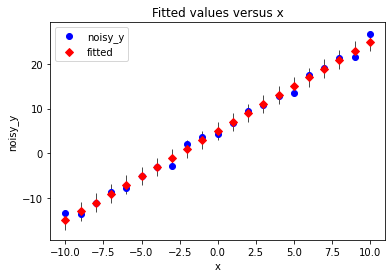

In [19]:
# plot the residuals
sm.graphics.plot_fit(f_model_noisy_results, 'x')

We can examine the results a bit further.  First, notice that the estimates of the coefficients now have a standard error and that the coefficients are not exactly the original values.  More importantly, if we look at the confidence intervals, we see that it is 95% confident that the intercept and slope, according to our assumption of Gaussian noise (which is the same noise we added), is going to fall in between (4.5, 5.4) and (1.9, 2.06), respectively.

Omnibus indicates whether (using the fitting function available for continuous distributions) our residuals are able to be described with a Normal (Gaussian) distribution.

For a refresher on all of the statistics that are output in the summary, see: https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a

You'll see that `statsmodels` can return a lot of different statistics about the regression model.

#### Impact of sample size on distribution estimates

Now, we'll visualize why we have to collect more samples in order to better estimate the noise distribution (since OLS assumes the same Gaussian error across all data).  You can think of this as the Nyquist frequency or Shannon sampling theorem in action!

<AxesSubplot:>

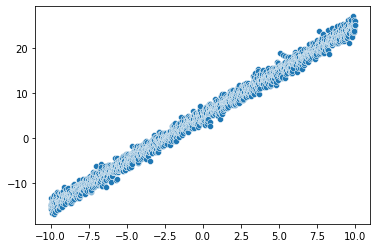

In [20]:
big_toy_sample_size = 2100
big_toy_sample_bound_left = -10.0
big_toy_sample_bound_right = 10.0

big_toy_x = np.linspace(start=big_toy_sample_bound_left,
                        stop=big_toy_sample_bound_right,
                        num=big_toy_sample_size)
big_toy_y = 2. * big_toy_x + 5.

# reset the random number generator to a known state so our experiment is consistent
big_noise_samples = dist_noise.rvs(size=len(big_toy_x), random_state=7)

big_toy_noisy_y = big_toy_y + big_noise_samples

sns.scatterplot(x=big_toy_x, y=big_toy_noisy_y)

In [21]:
df_big_toy_noisy = pd.DataFrame.from_dict(
    {"big_x": big_toy_x, "big_noisy_y": big_toy_noisy_y})
f_big_model_noisy = smf.ols(formula='big_noisy_y ~ big_x + 1', data=df_big_toy_noisy)
f_big_model_noisy_results = f_big_model_noisy.fit()
f_big_model_noisy_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            big_noisy_y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 2.838e+05
Date:                Fri, 09 Sep 2022   Prob (F-statistic):               0.00
Time:                        23:18:09   Log-Likelihood:                -2963.6
No. Observations:                2100   AIC:                             5931.
Df Residuals:                    2098   BIC:                             5942.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9594      0.022    228.917      0.000       4.917       5.002
big_x          1.9982      0.004    532.759      0.000       1.991       2.006
==============================================================================
Omnibus:                        0.077   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.962   Jarque-Bera (JB):                0.040
Skew:                           0.003   Prob(JB):                        0.980
Kurtosis:                       3.021   Cond. No.                         5.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Look at how tight the 95% confidence intervals are for the coefficients now!  You'll notice the standard error is much smaller as well, a magnitude or two smaller!  Even though our R-squared ("accuracy") is smaller, OLS is **much** more confident that we have the correct coefficients.

Try changing the sample size and see how many samples are needed to characterize the noise better!

#### Building models using real data

Datasets:
1. https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather
2. https://data.lacity.org/City-Infrastructure-Service-Requests/LADWP-Power-Outages/tdb2-bvuq
3. http://www.laalmanac.com/weather/we04a.php
4. https://www.californiadgstats.ca.gov/downloads/

We'll save this for class next time.